# Luxury Beauty Products Sentiment Analysis using Amazon Customer Reviews

*Team 11*

*Members - Ajay Valecha, Akshay Oza, Anmol Kapoor*

## Problem and Approach

**What is the Problem?**

E-commerce has become popular in the last decade. Thousands of products are sold through platforms like Amazon, eBay, etc. One of the biggest advantages of e-commerce platforms for both customers and sellers alike is an option to rate and review the products. These reviews can be used by businesses to make major business decisions based on price optimization, demand forecasts, product comparison with the competition. In the real world situation, businesses don’t have access to the sentiment label of the reviews provided by the customers. Through this project, we would like to explore different ways of  unsupervised sentiment analysis for luxury beauty products sold on Amazon and find insights for the features that work for the brand.

Today Luxury Beauty Products globally is 126 Billion USD Market with 18.8 Billion USD in US alone. More than 2000 products are sold on Amazon with wide range of brands, price and categories. 

**Who benefits?**

Luxury Beauty brands and Market Researchers/ Data Scientists who are involved in this kind of analysis.






## Data Cleaning and Processing 

### Data Structure and Dictionary

*Data Credit : Jianmo Ni, J. L. (2019). Justifying recommendations using distantly-labeled reviews and fined-grained aspects. . Empirical Methods in Natural Language Processing (EMNLP).*


**Some important variables**

`reviews.json`

-   reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- 	asin - ID of the product, e.g. 0000013714
- 	reviewerName - name of the reviewer
- 	vote - helpful votes of the review
-   style - a dictionary of the product metadata, e.g., "Format" is "Hardcover"
- **reviewText - text of the review**
-	overall - rating of the product
-	summary - summary of the review

`meta_data.json`

-	asin - ID of the product, e.g. 0000031852
-	title - name of the product
- description - description of the product
- price - price in US dollars (at time of crawl)






### Installing and Importing Required Libraries

In [ ]:
# Install following packages
#We used Google Colab. So had to mount the drive as well 
!pip install spacy
!pip install nltk
!pip install SimpSom
!pip install gensim
!pip install vaderSentiment

In [ ]:
#Import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import spacy
import nltk
import SimpSOM as sps
from gensim.models import Word2Vec, KeyedVectors
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_curve, roc_auc_score
import matplotlib as pyplot
from sklearn.decomposition import TruncatedSVD

# Note: Some packages have been imported later as well

### Loading, Merging and Cleaning the Data

The process we used for data cleaning and saving the cleaned data is as follows:

- Load the dataset, remove the duplicates from the meta data and merge the data
- Delete the irrelevant columns, drop the null rows (wherever necessary), impute null values (wherever necessary)
- Change the data type of certain columns and format them to create new columns
- Save the `cleaned_data.json` with `gzip` compression
- Filter the data for products with more than 3000 reviews
- Save the `top_prod_reviews.json` with `gzip` compression


In [ ]:
path= "/content/drive/MyDrive/DSPM/Luxury_Beauty.json.gz" #change it according to your drive folder

In [ ]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(path)

In [ ]:
df.shape

(574628, 12)

In [ ]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,2.0,3,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,1276560000,NaN,NaN
1,5.0,14,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,1262822400,NaN,NaN
2,5.0,NaN,True,"04 18, 2018",A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
3,5.0,NaN,True,"04 18, 2018",A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
4,5.0,NaN,True,"04 17, 2018",A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,1523923200,{'Size:': ' 3.5 oz.'},NaN


In [ ]:
meta_df= getDF("/content/drive/MyDrive/DSPM/meta_Luxury_Beauty.json.gz") #change path according to your drive folder

In [ ]:
meta_df.shape

(12299, 18)

In [ ]:
meta_df.head()

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin
0,[],,[After a long day of handling thorny situation...,,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...",[https://images-na.ssl-images-amazon.com/image...,,,[],"4,324 in Beauty & Personal Care (","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",{' Product Dimensions: ': '2.2 x 2.2 ...,Luxury Beauty,,,$30.00,B00004U9V2
1,[],,[If you haven't experienced the pleasures of b...,,AHAVA Bath Salts,[],[],,,[],"1,633,549 in Beauty & Personal Care (",[],{' Product Dimensions: ': '3 x 3.5 x ...,Luxury Beauty,,,,B0000531EN
2,[],,"[Rich, black mineral mud, harvested from the b...",,"AHAVA Dead Sea Mineral Mud, 8.5 oz, Pack of 4",[],[https://images-na.ssl-images-amazon.com/image...,,,[],"1,806,710 in Beauty &amp; Personal Care (",[],{' Product Dimensions: ': '5.1 x 3 x ...,Luxury Beauty,,,,B0000532JH
3,[],,[This liquid soap with convenient pump dispens...,,"Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...",[],[https://images-na.ssl-images-amazon.com/image...,,,[],[],"[B00004U9V2, B00GHX7H0A, B00FRERO7G, B00R68QXC...",{' Product Dimensions: ': '2.6 x 2.6 ...,Luxury Beauty,,,$15.99,B00005A77F
4,[],,[Remember why you love your favorite blanket? ...,,Soy Milk Hand Crme,"[B000NZT6KM, B001BY229Q, B008J724QY, B0009YGKJ...",[https://images-na.ssl-images-amazon.com/image...,,,[],"42,464 in Beauty &amp; Personal Care (",[],{' Product Dimensions: ': '7.2 x 2.2 ...,Luxury Beauty,,,$18.00,B00005NDTD


In [ ]:
meta_df_nodups= meta_df.loc[meta_df.astype(str).drop_duplicates().index] #deleting duplicate rows 

In [ ]:
merge_df= df.merge(meta_df_nodups, on="asin")#merging the dataframes

In [ ]:
merge_df.shape

(574338, 29)

In [ ]:
merge_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image_x,category,tech1,description,fit,title,also_buy,image_y,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price
0,2.0,3,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,1276560000,NaN,NaN,[],,[After a long day of handling thorny situation...,,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...",[https://images-na.ssl-images-amazon.com/image...,,,[],"4,324 in Beauty & Personal Care (","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",{' Product Dimensions: ': '2.2 x 2.2 ...,Luxury Beauty,,,$30.00
1,5.0,14,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,1262822400,NaN,NaN,[],,[After a long day of handling thorny situation...,,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...",[https://images-na.ssl-images-amazon.com/image...,,,[],"4,324 in Beauty & Personal Care (","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",{' Product Dimensions: ': '2.2 x 2.2 ...,Luxury Beauty,,,$30.00
2,5.0,NaN,True,"04 18, 2018",A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN,[],,[After a long day of handling thorny situation...,,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...",[https://images-na.ssl-images-amazon.com/image...,,,[],"4,324 in Beauty & Personal Care (","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",{' Product Dimensions: ': '2.2 x 2.2 ...,Luxury Beauty,,,$30.00
3,5.0,NaN,True,"04 18, 2018",A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN,[],,[After a long day of handling thorny situation...,,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...",[https://images-na.ssl-images-amazon.com/image...,,,[],"4,324 in Beauty & Personal Care (","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",{' Product Dimensions: ': '2.2 x 2.2 ...,Luxury Beauty,,,$30.00
4,5.0,NaN,True,"04 17, 2018",A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,1523923200,{'Size:': ' 3.5 oz.'},NaN,[],,[After a long day of handling thorny situation...,,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...",[https://images-na.ssl-images-amazon.com/image...,,,[],"4,324 in Beauty & Personal Care (","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",{' Product Dimensions: ': '2.2 x 2.2 ...,Luxury Beauty,,,$30.00


In [ ]:
merge_df.groupby('asin')['reviewerID'].count().to_frame().sort_values(by='reviewerID',ascending=False) #counting and sorting number of reviews for each product

,reviewerID
asin,
B0013U0EYI,6954
B00172O9NO,6138
B00176GSEI,5262
B0017SWIU4,4300
B0002ZW5UQ,3460
...,...
B00YZ3KWG0,1
B008H6MXCW,1
B008HRITQ0,1


**There are 12,000+ products in the dataset**

In [ ]:
merge_df.columns #list of all columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'style',
       'image_x', 'category', 'tech1', 'description', 'fit', 'title',
       'also_buy', 'image_y', 'tech2', 'brand', 'feature', 'rank', 'also_view',
       'details', 'main_cat', 'similar_item', 'date', 'price'],
      dtype='object')

In [ ]:
merge_df.isnull().sum() #counting nulls

overall                0
vote              470739
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          31
reviewText           399
summary              183
unixReviewTime         0
style             323353
image_x           566930
category               0
tech1                  0
description            0
fit                    0
title                  0
also_buy               0
image_y                0
tech2                  0
brand                  0
feature                0
rank                   0
also_view              0
details                0
main_cat               0
similar_item           0
date                   0
price                  0
dtype: int64

In [ ]:
merge_df.drop(columns=['verified', 'reviewTime','unixReviewTime', 'style',
       'image_x', 'category', 'tech1','image_y', 'tech2','main_cat', 'similar_item', 'date','brand','feature','details'],inplace=True)
#drop irrelevant columns

In [ ]:
merge_df['rank_amazon']= merge_df['rank'].apply(lambda x: str(x)).str.replace(',','').str.extract("(\d+)")
merge_df['rank_amazon']=pd.to_numeric(merge_df['rank_amazon']) #create a numeric column with rank

In [ ]:
merge_df['rank_amazon'].dtype

dtype('float64')

In [ ]:
merge_df['description']= merge_df['description'].apply(lambda x: str(x))
merge_df.head() #changing the dtype of description

In [ ]:
merge_df['desc']=merge_df['description'].apply(lambda x: x.replace('[',''))
merge_df.head() #formatting description column

In [ ]:
merge_df_copy= merge_df[merge_df['reviewText'].notnull()]
merge_df_copy=merge_df_copy[merge_df_copy['summary'].notnull()]
merge_df_copy.shape #removing null rows

(573764, 16)

In [ ]:
merge_df_copy['vote']= merge_df_copy['vote'].fillna(0)
merge_df_copy.head() #imputing null in vote column with 0

,overall,vote,reviewerID,asin,reviewerName,reviewText,summary,description,fit,title,also_buy,rank,also_view,price,rank_amazon,desc
0,2.0,3,A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,['After a long day of handling thorny situatio...,,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324 in Beauty & Personal Care (","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",$30.00,4324.0,'After a long day of handling thorny situation...
1,5.0,14,A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,['After a long day of handling thorny situatio...,,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324 in Beauty & Personal Care (","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",$30.00,4324.0,'After a long day of handling thorny situation...
2,5.0,0,A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,['After a long day of handling thorny situatio...,,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324 in Beauty & Personal Care (","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",$30.00,4324.0,'After a long day of handling thorny situation...
3,5.0,0,A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,['After a long day of handling thorny situatio...,,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324 in Beauty & Personal Care (","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",$30.00,4324.0,'After a long day of handling thorny situation...
4,5.0,0,A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,['After a long day of handling thorny situatio...,,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324 in Beauty & Personal Care (","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",$30.00,4324.0,'After a long day of handling thorny situation...


In [ ]:
merge_df_copy.to_json('/content/drive/MyDrive/DSPM/cleaned_data.json',compression='gzip') #writing the cleaned data file

In [ ]:
prod_keep= merge_df_copy.groupby('title')['reviewerID'].count().to_frame().sort_values('reviewerID',ascending=False)
prod_keep= prod_keep[prod_keep['reviewerID']>3000]
prod_keep.reset_index(inplace=True) #creating new dataframe with top products with more than 3000 reviews

In [ ]:
df_reviews= merge_df_copy[merge_df_copy['title'].isin(prod_keep['title'].to_list())]

In [ ]:
df_reviews.shape

(51174, 16)

In [ ]:
df_reviews = df_reviews.reset_index(drop=True)

In [ ]:
df_reviews.to_json('/content/drive/MyDrive/DSPM/top_prod_reviews.json', compression='gzip') #writing the top products json file

## Exploratory Data Analysis

- Understand the distribution of `price`, `overall` and `vote`. This will give us a sense of the range of the values and determine the main strong/ pain points

- Scatter Plots to determine correlation between our important variables

*Interpretationa and Insights can be found in key findings*

### Understanding Distribution

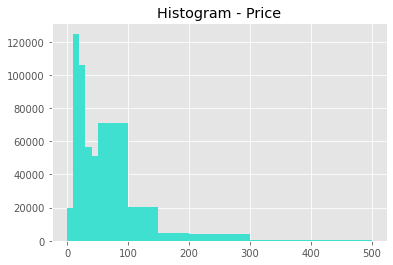

In [ ]:
plt.hist(df['price'],bins=[0,10,20,30,40,50,100,150,200,300,500],color='turquoise')
plt.title("Histogram - Price")
plt.savefig("Histogram - Price")

In [ ]:
df['overall'] = df.overall.astype(float)

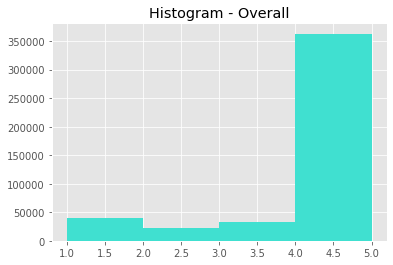

In [ ]:
overall = df['overall']
plt.hist(overall, bins = [1,2,3,4,5],color='turquoise')
plt.title("Histogram - Overall")
plt.savefig("Histogram - Overall")

In [ ]:
df['vote']= df['vote'].apply(lambda x: str(x)).str.replace(',','').str.extract("(\d+)")
df['vote']=pd.to_numeric(df['vote'])


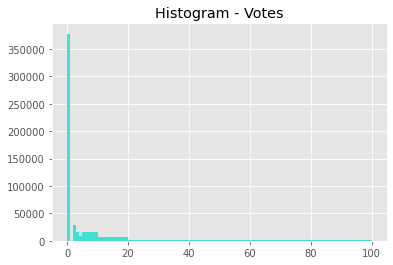

In [ ]:
vote = df['vote']
plt.hist(vote,bins=[0,1,2,3,4,5,10,20,30,50,100],color='turquoise')
plt.title("Histogram - Votes")
plt.savefig("Histogram - Votes")

### Understanding Correlations

In [ ]:
ov = df.groupby('asin')['overall'].mean().to_frame().rename(columns={"reviewerId":"Mean_Overall"})
pr = df.groupby('asin')['price'].mean().to_frame().rename(columns={"price":"Price"})

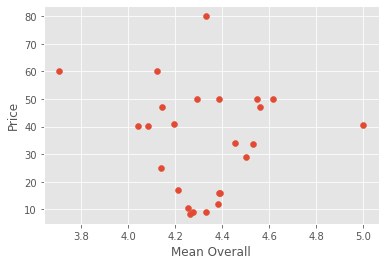

In [ ]:
plt.scatter(ov, pr)
plt.xlabel("Mean Overall")
plt.ylabel("Price")
plt.show()

In [ ]:
num_reviews = df.groupby('asin')['reviewerID'].count().to_frame()

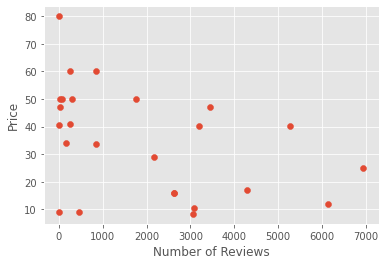

In [ ]:
plt.scatter(num_reviews, pr)
plt.xlabel("Number of Reviews")
plt.ylabel("Price")
plt.show()

In [ ]:
ran = df.groupby('asin')['rank_amazon'].mean().to_frame()

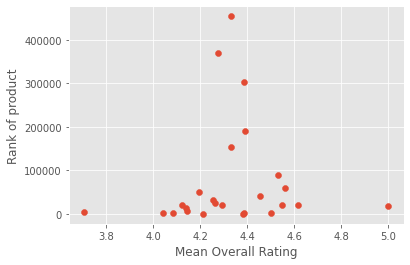

In [ ]:
plt.scatter(ov, ran)
plt.xlabel("Mean Overall Rating")
plt.ylabel("Rank of product")
plt.show()

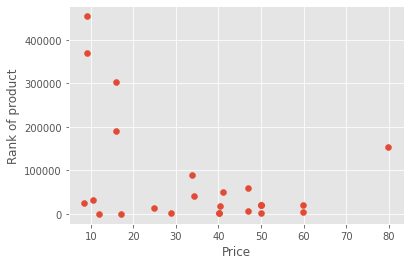

In [ ]:
plt.scatter(pr, ran)
plt.xlabel("Price")
plt.ylabel("Rank of product")
plt.show()

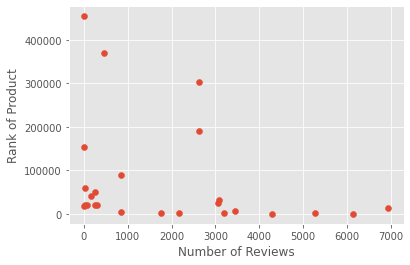

In [ ]:
plt.scatter(num_reviews, ran)
plt.xlabel("Number of Reviews")
plt.ylabel("Rank of Product")
plt.show()

### Key Findings

- The distribution for all 3 variables is highly skewed. Most of the reviews have an overall rating of 4 or 5. This means that majority of the customers are satisfied with the product. 
- The price range for most products is between 1USD to 100 USD. Most of the reviews don't have any votes.
- The relation between price and number of reviews is exponential to a certain extent and so is for the overall and rank. 

## Model and Products

After the Exploratory Data Analysis we narrowed down to 3 different products based on number of reviews and product categories.

We then used 3 models:
- VADER
- KMeans with Word2Vec
- KMeans with Self Organzing Maps

**Note: Following code is for one product , similar code was run for other products. These code files, saved predictions and scores can be found in the codefiles folder**

## VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.  
 
SentimentIntensityAnalyzer() is an object and polarity_scores is a method which will  give us scores of the following categories:
- Positive
-  Negative
-  Neutral
- Compound
  
The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive).
The more Compound score closer to +1, the higher the positivity of the text.

Process we followed:

- VADER SentimentAnalyzer() from nltk
- Calculated and mapped compound scores
- Compared them with true labels (reviews with overall rating 4/5) 

**Note: We did not use true labels for training. Just to evaluate how our models were performing**

### Load the data

In [ ]:
#Read in the data
reviews = pd.read_json("top_prod_reviews.json",compression="gzip")
reviews.head(3)



,overall,vote,reviewerID,asin,reviewerName,reviewText,summary,description,fit,title,also_buy,rank,also_view,price,rank_amazon,desc
2543,1,0,A1SJGHZDQHVYWH,B000142FVW,Julie D. Cassetina,Doesnt match the regular color of the real pro...,One Star,['Nail lacquer is the original nail polish for...,,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0...","[B000NG90UM, B002D4GYHE, B00178VX50, B00R2X2S7...","26,115 in Beauty & Personal Care (","[B000NG801C, B004220DOU, B0035YFH6K, B006JUVPS...",$8.40,26115,'Nail lacquer is the original nail polish form...
2544,3,0,A1EZAX4P346ABG,B000142FVW,James C. James,Not pigmented enough. Needed three coats and s...,Low pigment,['Nail lacquer is the original nail polish for...,,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0...","[B000NG90UM, B002D4GYHE, B00178VX50, B00R2X2S7...","26,115 in Beauty & Personal Care (","[B000NG801C, B004220DOU, B0035YFH6K, B006JUVPS...",$8.40,26115,'Nail lacquer is the original nail polish form...
2545,4,0,A1AT61K23ZY13Z,B000142FVW,Amazon Customer,I really liked the color of this polish. It wa...,I really liked the color of this polish,['Nail lacquer is the original nail polish for...,,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0...","[B000NG90UM, B002D4GYHE, B00178VX50, B00R2X2S7...","26,115 in Beauty & Personal Care (","[B000NG801C, B004220DOU, B0035YFH6K, B006JUVPS...",$8.40,26115,'Nail lacquer is the original nail polish form...


In [ ]:
#Focus on one product
prod3= reviews[reviews['asin']=="B00172O9NO"]
prod3.head(3)

,overall,vote,reviewerID,asin,reviewerName,reviewText,summary,description,fit,title,also_buy,rank,also_view,price,rank_amazon,desc
173529,5,23,A1FZMDMDM9D81Z,B00172O9NO,The Cat&#039;s Meow,I love this facial mist by Mario Badescu! It's...,Fresh!,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ..."
173530,5,0,A9U6XNKG8RYYI,B00172O9NO,Tise~,I use it as a facial spray at night and as a m...,I use it as a facial spray at night and ...,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ..."
173531,5,0,ACXEUZEAZ276A,B00172O9NO,Amazon Customer,This beauty stays in my handbag to help rehydr...,this is just perfect. It refreshes my skin and...,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ..."


In [ ]:
#Reindex
prod3 = prod3.reset_index(drop=True)

In [ ]:
#Turn the entire text into lowercase letters
prod3['reviewText']= prod3['reviewText'].apply(lambda x: x.lower())

### Text Preparation and Most Frequent Words

In [ ]:
#Tokenize the Data
nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words.add("product")
nlp.Defaults.stop_words.add("products")
nlp.Defaults.stop_words.add("facial")
nlp.Defaults.stop_words.add("spray")
nlp.Defaults.stop_words.add("mist")
nlp.Defaults.stop_words.add("mario")
nlp.Defaults.stop_words.add("badescu")
nlp.Defaults.stop_words.add("skin")
nlp.Defaults.stop_words.add("makeup")

In [ ]:
#Function to remove meaningless and stop words
def remove_stopwords(text):
  '''
  Args

  text : a string of product review

  Return:

  tokens: a string without stopwords and punctutaions
  '''
  tokens=[]
  doc=nlp(text)
  for word in doc:
    if word.is_stop==False:
      if word.is_punct==False:
        if word.pos_=='ADJ' or word.pos_=="NOUN" or word.pos_=="VERB":
          tokens.append(word.text)
  sentence = " ".join(tokens)

  
  return sentence

In [ ]:
#Apply function to remove meaningless and stop words
prod3['reviewsTokens']=prod3['reviewText'].apply(lambda x: remove_stopwords(x))

In [ ]:
#what are the top 10 most frequent words
split_it = []
for i in prod3['reviewsTokens']:
    split_it+=i.split()

text_top_counter= Counter(split_it)
text_top= []
text_top_counts= []
for k, v in text_top_counter.most_common(10):
    text_top.append(k)
    text_top_counts.append(v)
print(text_top)

['love', 'face', 'use', 'smells', 'great', 'refreshing', 'good', 'smell', 'day', 'amazing']


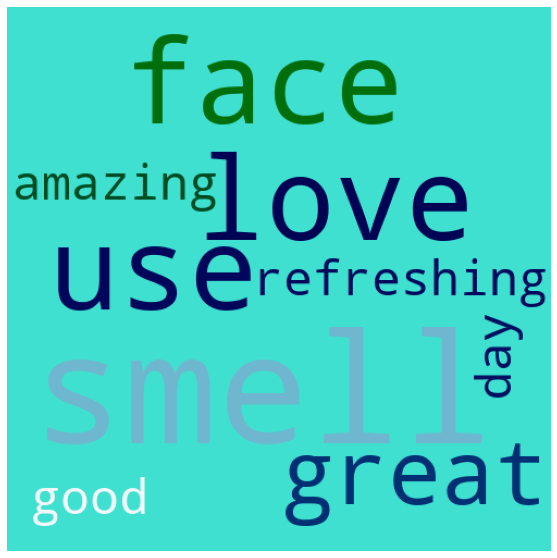

In [ ]:
#Plot top 10 words
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plot_it = " ".join(text_top)
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis("off");
wordcloud = WordCloud(width = 500, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(plot_it)
plot_cloud(wordcloud)

**As we can see most frequent words for this product are highly positive**

### Sentiment Analysis with VADER

In [ ]:
# import Vader 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
  
    # decide sentiment as positive and negative
    if sentiment_dict['compound'] >= 0.0 :
      result = "Positive"
  
    elif sentiment_dict['compound'] <  0.0 : 
      result = "Negative"
  
    return result

In [ ]:
prod3.shape

(6126, 17)

In [ ]:
# add verdict
def result_token(df):
  lst=[]
  for i in df['reviewsTokens']:
    output = sentiment_scores(i)
    lst.append(output)
  df['Verdict'] = lst
  return df

In [ ]:
result_token(prod3) #applied result token function

In [ ]:
#choose 3 columns only

prod3 = prod3[['reviewText','overall','Verdict']]
prod3.head(5)


,reviewText,overall,Verdict
0,i love this facial mist by mario badescu! it's...,5,Positive
1,i use it as a facial spray at night and as a m...,5,Negative
2,this beauty stays in my handbag to help rehydr...,5,Positive
3,love it! keep it in my bag and spritz myself t...,5,Positive
4,can you say miracle for my skin my skin is ver...,5,Positive


In [ ]:
#Turn into binary classification: Positive and Negative

change_nums = {"Verdict":     {"Positive": 1, "Negative": 0},
                "overall": {1: 0, 2: 0, 3: 0, 4: 1,5: 1}}
prod3 = prod3.replace(change_nums)
prod3.rename(columns = {'overall': 'sentiment','Verdict':'prediction'}, inplace = True)
prod3.head()



,reviewText,sentiment,prediction
0,i love this facial mist by mario badescu! it's...,1,1
1,i use it as a facial spray at night and as a m...,1,0
2,this beauty stays in my handbag to help rehydr...,1,1
3,love it! keep it in my bag and spritz myself t...,1,1
4,can you say miracle for my skin my skin is ver...,1,1


### Evaluating the VADER Results for Product 3

Random Chances: ROC AUC=0.500
Product 3: ROC AUC= 0.641
Product 3: Accuracy= 0.862
Product 3: Precision= 0.874
Product 3: Recall= 0.974
Product 3: f1= 0.922


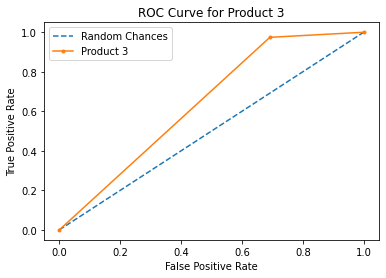

In [ ]:
# roc curve and auc

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(prod3['sentiment']))]

# calculate scores
ns_auc = roc_auc_score(prod3['sentiment'], ns_probs)
pro_1 = roc_auc_score(prod3['sentiment'], prod3['prediction'])
acc= accuracy_score(prod3['sentiment'],prod3['prediction'])
precision= precision_score(prod3['sentiment'],prod3['prediction'])
recall= recall_score(prod3['sentiment'],prod3['prediction'])
f1= f1_score(prod3['sentiment'],prod3['prediction'])


# summarize scores
print('Random Chances: ROC AUC=%.3f' % (ns_auc))
print('Product 3: ROC AUC= %.3f' % (pro_1))
print('Product 3: Accuracy= %.3f' % (acc))
print('Product 3: Precision= %.3f' % (precision))
print('Product 3: Recall= %.3f' % (recall))
print('Product 3: f1= %.3f' % (f1))



# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(prod3['sentiment'], ns_probs)
one_fpr, one_tpr, _ = roc_curve(prod3['sentiment'], prod3['prediction'])


# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Chances')
pyplot.plot(one_fpr, one_tpr, marker='.', label='Product 3')


# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
pyplot.title("ROC Curve for Product 3")
# show the plot
pyplot.show()

**A quite impressive Recall rate and F-1 Score**

In [ ]:
#Write output results to a txt file
output_file = open("Prod3.txt", "w")
output_file.write("{:.2f}\n".format(acc))
output_file.write("{:.2f}\n".format(precision))
output_file.write("{:.2f}\n".format(recall))
output_file.write("{:.2f}".format(f1))
output_file.close()

In [ ]:
#keeping the required dataset
prod3.to_json('prod3_Vader_predictions.json',compression='gzip')

## K-Means Clustering with Word2Vec Model

Word2Vec uses a Neural Network model to learn association between words . Can either be trained from the data by creating a vocabulary or by using the pre-trained corpus

The process we followed-

- Text Preparation with tokenization and lemmatization
- Created and Trained a Word2Vec model using `gensim` 
- Clustered using K-means and determined positive and negative cluster based on words
- Created Tf-IDF vectors 
- Mapped the sentiment coefficients to tokens in the reviews as well as tf-idf vectors
- Dot product of these two vectors for each review gives us the sentiment. 1 is positive 0 is negative

### Load the Top Product Reviews Data and Create a Subset for Product 3 - Mario Badescu Facial Spray

In [ ]:
reviews= pd.read_json("top_prod_reviews.json",compression="gzip")
reviews.head()

In [ ]:
prod3= reviews[reviews['asin']=='B00172O9NO'] #filtering the reviews for this particular product
prod3.head()

,overall,vote,reviewerID,asin,reviewerName,reviewText,summary,description,fit,title,also_buy,rank,also_view,price,rank_amazon,desc
173529,5,23,A1FZMDMDM9D81Z,B00172O9NO,The Cat&#039;s Meow,I love this facial mist by Mario Badescu! It's...,Fresh!,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ..."
173530,5,0,A9U6XNKG8RYYI,B00172O9NO,Tise~,I use it as a facial spray at night and as a m...,I use it as a facial spray at night and ...,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ..."
173531,5,0,ACXEUZEAZ276A,B00172O9NO,Amazon Customer,This beauty stays in my handbag to help rehydr...,this is just perfect. It refreshes my skin and...,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ..."
173532,5,0,A7SJJ5JNG94XS,B00172O9NO,Amazon Customer,love it! keep it in my bag and spritz myself t...,love it! keep it in my bag and spritz ...,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ..."
173533,5,0,A2TWZFOKWB0O29,B00172O9NO,Crystal Hernandez,Can you say miracle for my skin my skin is ver...,Miracle for my skin,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ..."


In [ ]:
prod3.shape

(6126, 16)

### Text Preparation

In [ ]:
prod3['reviewText']= prod3['reviewText'].apply(lambda x: x.lower())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
nlp= spacy.load("en_core_web_sm") #loading spacy and adding stopwords
nlp.Defaults.stop_words.add("facial")
nlp.Defaults.stop_words.add("spray")
nlp.Defaults.stop_words.add("mist")
nlp.Defaults.stop_words.add("mario")
nlp.Defaults.stop_words.add("badescu")
nlp.Defaults.stop_words.add("skin")
nlp.Defaults.stop_words.add("product")
nlp.Defaults.stop_words.add("products")

In [ ]:
def remove_stopwords(text): #custom tokenizer with emphasis on nouns, adjective and verbs
  '''
  Args

  text : a string of product review

  Return:

  tokens: a list of tokens without stopwords and punctutaions
  '''
  tokens=[]
  doc=nlp(text)
  for word in doc:
    if word.is_stop==False:
      if word.is_punct==False:
        if word.pos_=='ADJ' or word.pos_=="NOUN" or word.pos_=="VERB":
          tokens.append(word.text)
  
  return tokens

In [ ]:
prod3['reviewsTokens']=prod3['reviewText'].apply(lambda x: remove_stopwords(x)) #applying stop words to the review text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Word2Vec Model

In [ ]:
sent = [row for row in prod3['reviewsTokens'].to_list()]

In [ ]:
wv_model= Word2Vec(min_count=5,window=4,size=300)

In [ ]:
wv_model.build_vocab(sent) #building word2Vec vocabulary

In [ ]:
wv_model.train(sent, total_examples= wv_model.corpus_total_words,epochs=30, report_delay=1)
wv_model.init_sims(replace=True) #training and mapping similarity probabilities

In [ ]:
wv_model.save("w2vModel_prod3.model")

In [ ]:
word_vectors= Word2Vec.load("w2vModel_prod3.model").wv

In [ ]:
word_vectors.vectors.shape

(1369, 300)

### K Means Clustering with Word2Vec

In [ ]:
model_kmeans=KMeans(n_clusters=2, max_iter=10000, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [ ]:
word_vectors.similar_by_vector(model_kmeans.cluster_centers_[0], topn=50,restrict_vocab=None)

[('exact', 0.940514326095581),
 ('disappoint', 0.9379125833511353),
 ('produce', 0.934934139251709),
 ('older', 0.9216790199279785),
 ('hyped', 0.9185928106307983),
 ('comments', 0.9180516004562378),
 ('tested', 0.9158099889755249),
 ('mother', 0.9143916964530945),
 ('search', 0.9124948978424072),
 ('samples', 0.9122572541236877),
 ('book', 0.9089068174362183),
 ('quarter', 0.9054259061813354),
 ('birthday', 0.9044948816299438),
 ('photo', 0.9033135175704956),
 ('opposite', 0.9017788171768188),
 ('zits', 0.8999792337417603),
 ('filled', 0.894506573677063),
 ('fewer', 0.8919343948364258),
 ('fair', 0.8910698294639587),
 ('returning', 0.8887037634849548),
 ('recent', 0.8866732716560364),
 ('soaked', 0.8864898681640625),
 ('cancer', 0.8831316828727722),
 ('arm', 0.8825122117996216),
 ('advertised', 0.8823010325431824),
 ('listen', 0.8819247484207153),
 ('pictures', 0.8800514936447144),
 ('description', 0.8759095668792725),
 ('changing', 0.8752049207687378),
 ('delivered', 0.87469452619552

In [ ]:
positive_cluster_index = 1   #defining clusters
positive_cluster_center = model_kmeans.cluster_centers_[positive_cluster_index]
negative_cluster_center = model_kmeans.cluster_centers_[1-positive_cluster_index]

In [ ]:
words = pd.DataFrame(word_vectors.vocab.keys())
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model_kmeans.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])
words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model_kmeans.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [ ]:
words.head(10)

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,love,"[0.054054536, -0.039824, 0.021605821, 0.090243...",1,1,1.085381,1.085381
1,expect,"[-0.06700812, -0.018236598, 0.021113714, 0.069...",0,-1,1.149298,-1.149298
2,refreshing,"[-0.009741704, 0.013952433, 0.033470094, 0.001...",1,1,1.113319,1.113319
3,smells,"[0.06828068, 0.02422702, 0.057187192, -0.05174...",1,1,1.017230,1.017230
4,nice,"[-0.04043596, -0.008818817, 0.037602156, 0.061...",1,1,1.097610,1.097610
5,sprays,"[0.053206764, 0.02214973, 0.06405523, 0.027011...",1,1,0.970828,0.970828
6,purse,"[0.07565121, 0.008380029, 0.05446421, 0.142871...",1,1,1.007161,1.007161
7,sized,"[0.061913114, 0.029173922, 0.055918306, 0.1139...",0,-1,1.196492,-1.196492
8,looking,"[0.03614129, -0.049314924, 0.08394348, -0.0611...",1,1,1.049559,1.049559
9,summer,"[-0.0662204, 0.101047315, 0.07224134, 0.026967...",1,1,1.065589,1.065589


In [ ]:
words[['words', 'sentiment_coeff']].to_csv('prod3_sentiment_dictionary.csv', index=False) #saving sentiment dictionary

### TF-IDF Vectorizer and Word2Vec Vectors

In [ ]:
prod3['token_sent']= prod3['reviewsTokens'].apply(lambda x: ' '.join(w for w in x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
tf= TfidfVectorizer(tokenizer=remove_stopwords)
tf.fit(prod3['reviewText'])
features=pd.Series(tf.get_feature_names())
transformed = tf.transform(prod3['reviewText'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [ ]:
prod3_justtxt= prod3['token_sent'].reset_index().drop('index',axis=1)

In [ ]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    Return:

    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    Args:

    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    Return:
    list: replacing each word with it's calculated tfidf dictionary with scores of each word

    Args:
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], x.token_sent.split()))

In [ ]:
replaced_tfidf_scores = prod3_justtxt.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)#converting text to tf-idf vectors and sentiment vectors

In [ ]:
def replace_sentiment_words(word, sentiment_dict):
    '''
    Return
    replacing each word with its associated sentiment score from sentiment dict

    Args:
    word: single token text
    sentiment_dict: Dictionary created with Word2Vec Model with K Means Clustering
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [ ]:
sentiment_map = pd.read_csv('prod3_sentiment_dictionary.csv')
sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))

In [ ]:
replaced_closeness_scores = prod3.token_sent.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split()))).reset_index()

### Prediction Using Sentiment Coefficients and TF-IDF Scores

In [ ]:
prod3['rate']=prod3['overall'].apply(lambda x: 1 if x>3 else -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
replaced_closeness_scores=replaced_closeness_scores.drop('index',axis=1).squeeze()
prod1_reviews= prod3['reviewText'].reset_index().drop('index',axis=1).squeeze()
prod1_rate= prod3['rate'].reset_index().drop('index',axis=1).squeeze()

In [ ]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, prod1_reviews, prod1_rate]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence', 'sentiment']

In [ ]:
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')
replacement_df['sentiment'] = [1 if i==1 else 0 for i in replacement_df.sentiment]

In [ ]:
replacement_df.head()

,sentiment_coeff,tfidf_scores,sentence,sentiment,sentiment_rate,prediction
0,"[1.0853811938791746, -1.1492975661110274, 1.11...","[0.14384660590286968, 0.45041268078504226, 0.1...",i love this facial mist by mario badescu! it's...,1,1.073106,1
1,"[1.1673462474982024, 1.1458459299294674, 1.140...","[0.19969344246136544, 0.3576564760316081, 0.21...",i use it as a facial spray at night and as a m...,1,1.351234,1
2,"[0.9673869996812434, 1.4170756085891307, 0, 1....","[0.1557477301823639, 0.2242495321936934, 0.248...",this beauty stays in my handbag to help rehydr...,1,-0.550113,0
3,"[1.0853811938791746, -1.1029119953340638, 1.19...","[0.13615069589496348, 0.3451754542465258, 0.29...",love it! keep it in my bag and spritz myself t...,1,2.792346,1
4,"[-1.4109101747299142, 1.1185383255535568, -1.2...","[0.263875825246971, 0.13023229880481388, 0.292...",can you say miracle for my skin my skin is ver...,1,0.255195,1


In [ ]:
replacement_df.to_json('prod3_KmeansWord2Vec_predictions.json',compression='gzip')

### Evaluating the K-Means with Word2Vec Model for Product 3

In [ ]:
acc= accuracy_score(replacement_df['sentiment'],replacement_df['prediction'])
precision= precision_score(replacement_df['sentiment'],replacement_df['prediction'])
recall= recall_score(replacement_df['sentiment'],replacement_df['prediction'])
f1= f1_score(replacement_df['sentiment'],replacement_df['prediction'])

In [ ]:
acc

0.7959516813581456

In [ ]:
precision

0.923721340388007

In [ ]:
recall

0.8225363172359639

In [ ]:
f1

0.8701973001038422

**Better Precision than VADER but lower recall and F-1 score**

In [ ]:
scores= [acc,precision,recall,f1]
with open("prod3_Kmeans_Word2Vec_scores.txt","w") as f:
  for i in scores:
    f.write("%.2f\n"%i) #writing scores to the disk

## K-Means Clustering with Simple Self-Organized Maps for Product 3

Self Organizing Maps are Unsupervised Clustering Neural Network model

Process:
- Initialize Weights
- Random Data Point
- Euclidean Distance
- Update Weights 
- Repeat

Steps we took :
- Create a TF -IDF vectorizer and truncate the vectors 
- Use SimpSOM package in Python to create a Self Organizing model
- Created and Trained a 20x20 Node Network (default and most commonly used value)
- We then clustered it using K-Means and compared the sentiment and prediction


In [ ]:
tf= TfidfVectorizer(tokenizer=remove_stopwords) #create tf-idf vectorizer
reviews_data= tf.fit_transform(prod3['reviewText'])
svd= TruncatedSVD(100,random_state=42)
reviews_de= svd.fit_transform(reviews_data)

In [ ]:
net= sps.somNet(20,20,reviews_de,PBC=True)#create and train the self organizing maps 

Periodic Boundary Conditions active.
The weights will be initialised randomly.


In [ ]:
net.train(0.01,5000)

Training SOM... done!


In [ ]:
net.save('weightsSOM_prod3')

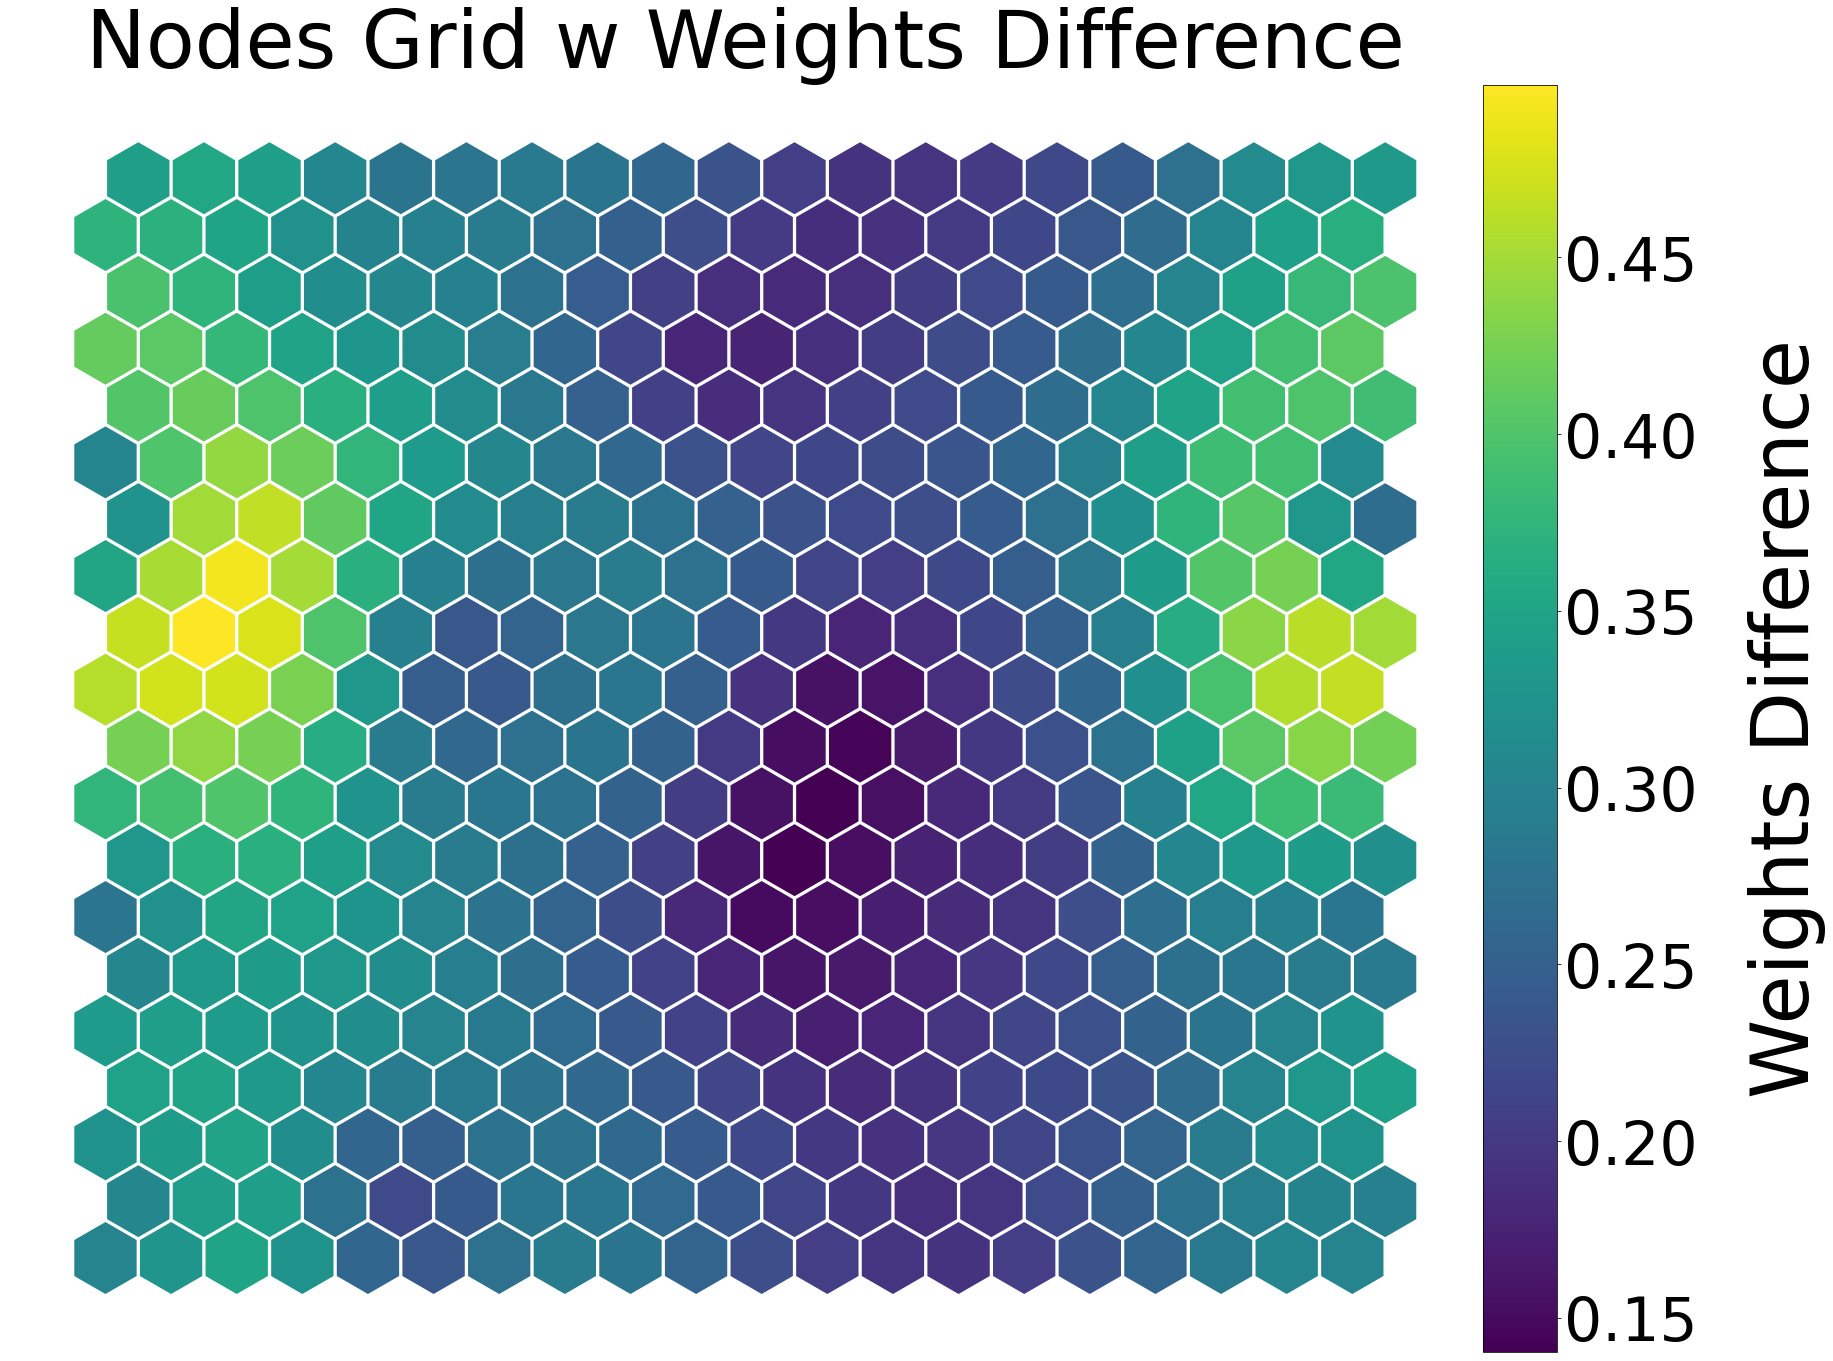

In [ ]:
net.diff_graph()

**From the difference graph we can see the clusters for nodes/neurons forming** 

In [ ]:
prj= np.array(net.project(reviews_de))

<Figure size 432x288 with 0 Axes>

In [ ]:
prod3_som= prod3[['reviewText','rate']].reset_index().drop('index',axis=1)
prod3_som.rename(columns={'rate':'sentiment'},inplace=True)
prod3_som.head()


,reviewText,sentiment
0,i love this facial mist by mario badescu! it's...,1
1,i use it as a facial spray at night and as a m...,1
2,this beauty stays in my handbag to help rehydr...,1
3,love it! keep it in my bag and spritz myself t...,1
4,can you say miracle for my skin my skin is ver...,1


In [ ]:
kmeans= KMeans(n_clusters=2,random_state=True).fit(prj) #k-means cluster and defining positive and negative cluster

In [ ]:
prod3_som['prediction']=kmeans.labels_ #create a prediction column

In [ ]:
prod3_som[prod3_som['prediction']==1].head()

,reviewText,sentiment,prediction
2,this beauty stays in my handbag to help rehydr...,1,1
4,can you say miracle for my skin my skin is ver...,1,1
10,pretty good for the price.,1,1
11,wow... sooo i had clear skin in hs but then st...,1,1
12,great buy thank you,1,1


In [ ]:
prod3_som['sentiment']=prod3_som['sentiment'].apply(lambda x: 1 if x==1 else 0)

In [ ]:
prod3_som.to_json('prod3_KmeansSOM.json',compression='gzip') #write the predictions

### Evaluating the KMeans with SOM for Product 3

In [ ]:
acc=accuracy_score(prod3_som['sentiment'],prod3_som['prediction']) #calculate scores

In [ ]:
precision=precision_score(prod3_som['sentiment'],prod3_som['prediction'])

In [ ]:
recall=recall_score(prod3_som['sentiment'],prod3_som['prediction'])

In [ ]:
f1=f1_score(prod3_som['sentiment'],prod3_som['prediction'])

In [ ]:
acc, precision,recall,f1

(0.410871694417238,
 0.8278145695364238,
 0.36808009422850413,
 0.5095801059926621)

**Perform poorly across all metrics when compared to VADER and Kmeans with Word2Vec**

In [ ]:
scores= [acc,precision,recall,f1]
with open("prod3_Kmeans_SOM_scores.txt","w") as f:
  for i in scores:
    f.write("%.2f\n"%i) #write scores for the model

## Evaluating Models on all 3 Products

In [ ]:
scores={'Product':['Product 1','Product 1','Product 1','Product 2','Product 2','Product 2','Product 3','Product 3','Product 3'],\
        'Model':['VADER','KMeans Word2Vec','KMeans SOM','VADER','KMeans Word2Vec','KMeans SOM','VADER','KMeans Word2Vec','KMeans SOM'],\
        'Accuracy':[],'Precision':[],'Recall':[],'F-1':[]}

In [ ]:
def read_scores(file): #reading from scores file and adding values to the scores dictionary
  with open(file,'r') as f:
    scores_list=[]
    for line in f:
      s= line.strip('\n')
      scores_list.append(s)
    scores['Accuracy'].append(float(scores_list[0]))
    scores['Precision'].append(float(scores_list[1]))
    scores['Recall'].append(float(scores_list[2]))
    scores['F-1'].append(float(scores_list[3]))


In [ ]:
read_scores('Prod1_Vader.txt')
read_scores('prod1_Kmeans_Word2Vec_scores.txt')
read_scores('prod1_Kmeans_SOM_scores.txt')
read_scores('Prod2_Vader.txt')
read_scores('prod2_Kmeans_Word2Vec_scores.txt')
read_scores('prod2_Kmeans_SOM_scores.txt')
read_scores('Prod3_Vader.txt')
read_scores('prod3_Kmeans_Word2Vec_scores.txt')
read_scores('prod3_Kmeans_SOM_scores.txt')

In [ ]:
scores_df= pd.DataFrame(scores) #df for scores data
scores_df

,Product,Model,Accuracy,Precision,Recall,F-1
0,Product 1,VADER,0.85,0.84,0.99,0.91
1,Product 1,KMeans Word2Vec,0.69,0.90,0.68,0.77
2,Product 1,KMeans SOM,0.46,0.71,0.54,0.61
3,Product 2,VADER,0.79,0.83,0.93,0.88
4,Product 2,KMeans Word2Vec,0.55,0.80,0.56,0.66
5,Product 2,KMeans SOM,0.50,0.76,0.51,0.61
6,Product 3,VADER,0.86,0.87,0.97,0.92
7,Product 3,KMeans Word2Vec,0.80,0.92,0.82,0.87
8,Product 3,KMeans SOM,0.41,0.83,0.37,0.51


In [ ]:
prod1_scores= scores_df[scores_df.Product=='Product 1']
prod2_scores= scores_df[scores_df.Product=='Product 2']
prod3_scores= scores_df[scores_df.Product=='Product 3']

In [ ]:
prod1_scores.style.highlight_max(color = 'lightgreen', axis = 0)


,Product,Model,Accuracy,Precision,Recall,F-1
0,Product 1,VADER,0.850000,0.840000,0.990000,0.910000
1,Product 1,KMeans Word2Vec,0.690000,0.900000,0.680000,0.770000
2,Product 1,KMeans SOM,0.460000,0.710000,0.540000,0.610000


In [ ]:
prod2_scores.style.highlight_max(color = 'lightgreen', axis = 0)

,Product,Model,Accuracy,Precision,Recall,F-1
3,Product 2,VADER,0.790000,0.830000,0.930000,0.880000
4,Product 2,KMeans Word2Vec,0.550000,0.800000,0.560000,0.660000
5,Product 2,KMeans SOM,0.500000,0.760000,0.510000,0.610000


In [ ]:
prod3_scores.style.highlight_max(color = 'lightgreen', axis = 0)

,Product,Model,Accuracy,Precision,Recall,F-1
6,Product 3,VADER,0.860000,0.870000,0.970000,0.920000
7,Product 3,KMeans Word2Vec,0.800000,0.920000,0.820000,0.870000
8,Product 3,KMeans SOM,0.410000,0.830000,0.370000,0.510000


**We can see that VADER outperforms when it comes to recall and f-1 but KMeans is great when it comes to precision.**

## Conclusion, Recommendation and Future Steps

### Business Recommendation

- From our analysis we found that there is an exponentital relation between the price and number of reviews. More the reviews can also be correlated with the popularity of the product

- For Luxury Brands to make their ranking on amazon and get more positive sentiments they need to create strong descriptions as well as use the sentiments from these products for price optimization

- For market researchers, different unsupervised sentiment analysis techniques can go a long way rather than just abiding by the rule based or corpus based approach. 





### Data Science Recommendations

- If the decision makers care about recall and F-1 Score, VADER is a good model. If they care about Precision alone, they can use K-Means with Word2Vec

- The models we used are not very optimized. Especially SOM which requires more data as well as computationally faster infrastructure. We can fine-tune them to create as good results as VADER. 

- More expertise from Beauty Product experts can help us decide more ways to prepare the text and remove/modify tokens accordingly